In [1]:
import HTC

import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

from scipy.interpolate import InterpolatedUnivariateSpline
from tqdm import tqdm

# Supra-threshold avalanches

In [2]:
act = np.loadtxt('results/connectome/connectome_66_0.0_1.5_0.01_50_0.73_0_series.txt')

act, act_norm = act[:len(act)//2], act[len(act)//2:]
series = act_norm[len(act)//2]

series = act[1]#[3000:3000+80]

T = len(series)
t = np.arange(T)

mean = np.mean(series)
std = np.std(series)

y_star = mean #* 4/5 #+ std/5
y_star = np.median(series)

#y_star = mean * 6/5 #+ std/5
print(y_star)
print(y_star.shape)

0.2424242
()


In [3]:
@jit(nopython=True)
def hline_intersection(x1, y1, x2, y2, y_star):
    '''
    Get intersection btw lines through two points and hline
    '''
    if np.sum((y1-y2)==0)>0:
        print('hline_intersection: the y\'s are equal')
    return (x1 - x2) / (y1 - y2) * (y_star - y2) + x2

In [4]:
#---------- AVALANCHES ----------
@jit(nopython=True)
def get_intersection(arr, y_star):
    '''
    Get all the intersection btw array and a hline
    '''
    # Increase intersection
    start = np.where( (arr[:-1]<=y_star) * (y_star<arr[1:]) )[0]
    # Decrease intersection
    stop = np.where( (arr[:-1]>y_star) * (y_star>=arr[1:]) )[0]
    
    # Check if empty
    if len(start)<1 or len(stop)<1:
        return np.empty(0), np.empty(0)
    
    # Check that first start is smaller than first stop
    if start[0]>stop[0]:
        stop = np.delete(stop, 0)
    # Check that last stop is bigger than last start
    if stop[-1]<start[-1]:
        start = np.delete(start, -1)
        
    # Check if empty
    if len(start)<1 or len(stop)<1:
        return np.empty(0), np.empty(0)
    
    # Get intersection with hline
    start = hline_intersection(start, arr[start], start+1, arr[start+1], y_star)
    stop = hline_intersection(stop, arr[stop], stop+1, arr[stop+1], y_star)
    
    return start, stop


@jit(nopython=True)
def get_avalanches(arr, y_star):
    '''
    Get sizes and lifetimes of avalanches in a single run
    '''
    T = len(arr)
    t = np.arange(T)
    
    # Get start and stop of avalanches
    start, stop = get_intersection(arr, y_star)
    
    # Check if empty
    if len(start)<1 or len(stop)<1:
        return np.empty(0), np.empty(0)
    
    # Compute avalanche time
    dt = stop - start
    
    # Compute avalanche size as activity area
    I = np.zeros(len(start))
    
    for i in range(len(start)):
        # Get point btw each start and stop
        t_in = t[(t>start[i])*(t<stop[i])]
        y_in = arr[t_in]
    
        # Append start and stop
        t_in = np.hstack(( np.array([start[i]]), t_in, np.array([stop[i]]) ))
        y_in = np.hstack(( np.array([y_star]), y_in, np.array([y_star]) ))
    
        # Integrate spline
        I[i] = np.trapz(y=y_in, x=t_in)
        
    return I, dt


@jit(nopython=True)
def get_avalanches_pdf(data):
    '''
    Return avalanches histogram from series of runs.
    '''
    av_size = np.array([0.0])
    av_time = np.array([0.0])
    
    runs = data.shape[0]
    
    for i in prange(runs):
        tmp_size, tmp_time = get_avalanches(data[i], np.median(data[i]))
        av_size = np.hstack((av_size, tmp_size))
        av_time = np.hstack((av_time, tmp_time))
        
    # Remove fake 0 as first element
    av_size = np.delete(av_size, 0)
    av_time = np.delete(av_time, 0)
    
    return av_size, av_time

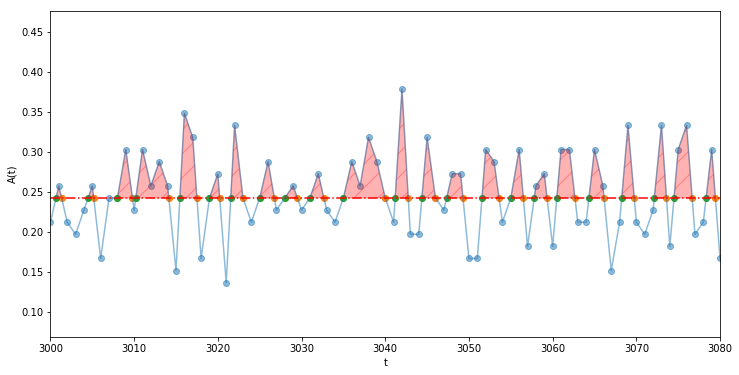

In [6]:
start, stop = get_intersection(series, y_star)

plt.figure(figsize=(12,6))

plt.plot(t, series[t], alpha=0.5)
plt.scatter(t, series[t], alpha=0.5)
plt.xlabel('t')
plt.ylabel('A(t)')

plt.scatter(stop, [y_star]*len(stop))
plt.scatter(start, [y_star]*len(start))

#plt.axhline(mean, ls='-.')
plt.axhline(y_star, ls='-.', c='r')

I = []


for i in range(len(start)):
    # Get point btw each start and stop
    t_in = t[(t>start[i])*(t<stop[i])]
    y_in = series[t_in]
    
    # Append start and stop
    t_in = np.hstack([start[i], t_in, stop[i]])
    y_in = np.hstack([y_star, y_in, y_star])
    #print('t: ', t_in)
    #print('y: ', y_in)
    
    # Integrate
    I.append( np.trapz(y=y_in, x=t_in) )
    
    plt.fill(t_in, y_in, c='r', hatch='/', alpha=0.3)

plt.xlim([3000, 3000+80])

plt.show()

In [ ]:
len(stop)

In [7]:
dt, I = [], []
dt_norm, I_norm = [], []

#run = 50
for run in tqdm(range(len(act))):
    # Define upper limit
    y_star = np.mean(act[run]) + np.std(act[run]) #/2
    
    # Get avalanche for specific run
    tmp_I, tmp_dt = get_avalanches(act[run], y_star)
    
    I.append(tmp_I)
    dt.append(tmp_dt)
    
dt = np.hstack(dt)
I = np.hstack(I)

100%|██████████| 151/151 [00:08<00:00, 18.49it/s]


In [8]:
Nbins = 50

hist_dt = np.histogram(dt, bins=Nbins)
hist_I = np.histogram(I, bins=Nbins)

hist_dt = np.array( [ (hist_dt[1][1:] + hist_dt[1][:-1])/2, hist_dt[0] ] )
hist_I = np.array( [ (hist_I[1][1:] + hist_I[1][:-1])/2, hist_I[0] ] )

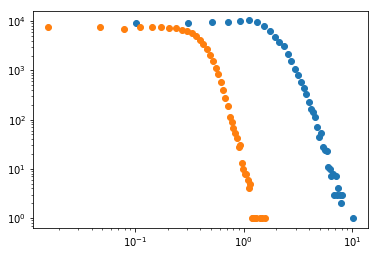

In [9]:
plt.figure()

plt.xscale('log')
plt.yscale('log')
plt.plot( hist_dt[0], hist_dt[1], 'o')
plt.plot( hist_I[0], hist_I[1], 'o')

plt.show()

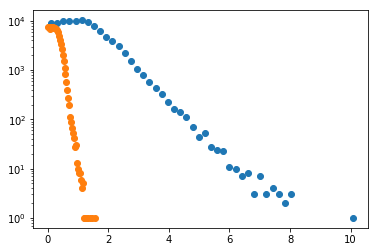

In [10]:
plt.figure()

#plt.xscale('log')
plt.yscale('log')
plt.plot( hist_dt[0], hist_dt[1], 'o')
plt.plot( hist_I[0], hist_I[1], 'o')

plt.show()

# Causal Avalanches

In [11]:
from numba import jit, prange
from numba.typed import List

import numpy as np
import matplotlib.pyplot as plt

from HTC_utils import *

In [21]:
N = 66
runs = 50
steps = 6000

r1 = 2 / N
r2 = r1**(1/5)
T = r2 / (1. + 2.*r2)
#T = 0.01

W = np.random.random((N, N))

S0 = np.random.randint(-1,2, (runs, N))
s0 = (S0==1).astype(int)

aval0 = (S0==1) * np.arange(1,N+1)
aval0 = aval0.astype(np.int32)

In [22]:
S = np.zeros((steps, runs, N))
aval = np.zeros((steps, runs, N))
S[0] = S0
aval[0] = aval0

for i in range(1,steps):
    S[i], s, aval[i] = update_state(S[i-1], W, T, r1, r2, aval[i-1], i)

In [23]:
tt = aval[:,0] # get run 0
ss = S[:,0]

In [24]:
aval_series = get_causal_avalanches(tt)

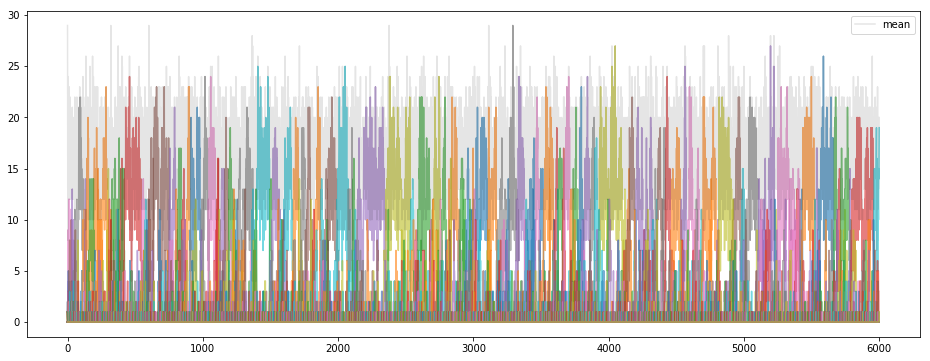

In [26]:
plt.figure(figsize=(16,6))
for i in range(len(aval_series)):
    plt.plot(aval_series[i], alpha=0.6)
plt.plot(np.mean(ss>0,axis=1)*N, c='k', alpha=0.1, label='mean')
plt.legend()
plt.show()

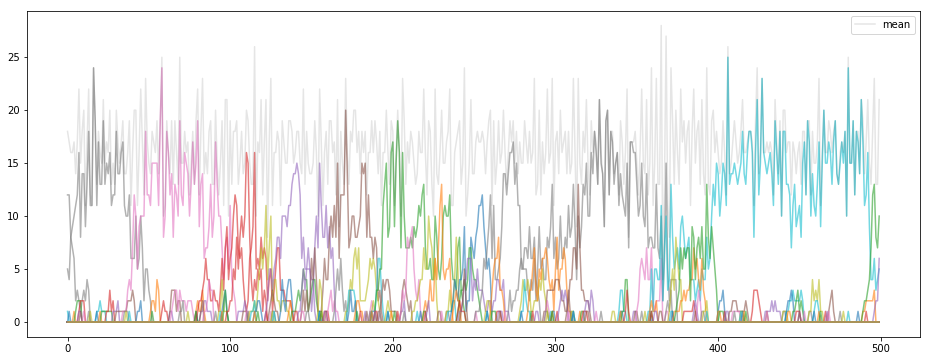

In [27]:
T = 500

plt.figure(figsize=(16,6))
for i in range(len(aval_series)):
    plt.plot(aval_series[i][1000:1000+T], alpha=0.6)
plt.plot(np.mean(ss>0,axis=1)[1000:1000+T]*N, c='k', alpha=0.1, label='mean')
plt.legend()
plt.show()

In [16]:
sizes, times = getCausalAvalPdf(aval)

NameError: name 'getCausalAvalPdf' is not defined

In [ ]:
size_hist = np.histogram(sizes, bins=15, density=True)
size_hist = np.array([ (size_hist[1][1:]+size_hist[1][:-1])/2, size_hist[0] ])

time_hist = np.histogram(times, bins=15, density=True)
time_hist = np.array([ (time_hist[1][1:]+time_hist[1][:-1])/2, time_hist[0] ])

In [ ]:
plt.figure()

plt.xscale('log')
plt.yscale('log')

plt.plot(size_hist[0], size_hist[1], 'o')
plt.plot(time_hist[0], time_hist[1], 'o')

plt.show()

In [ ]:
size_hist[0]

In [ ]:
sizes, times = get_causal_avalanches_pdf(aval)

In [ ]:
plt.figure()

plt.xscale('log')
plt.yscale('log')

plt.plot(hist_size[0], hist_size[1] / sum(hist_size[1]), 'o')
plt.plot(hist_time[0], hist_time[1] / sum(hist_time[1]), 'o')

plt.show()

In [ ]:
sizes

In [ ]:
times